# Unsupervised ML: Credit Card User Segmentation

In [11]:
# import block
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [2]:
# import data
data = pd.read_csv("CC_GENERAL.csv", sep=",")
data_np = np.genfromtxt("CC_GENERAL.csv", delimiter=",")

print(data.shape)
data.head(10)

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


## 1. Dataset

In [3]:
data.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS    313
CREDIT_LIMIT          1
CUST_ID               0
BALANCE               0
PRC_FULL_PAYMENT      0
dtype: int64

Replace null values with mean values. I consulted [this notebook](https://www.kaggle.com/sabanasimbutt/clustering-visualization-of-clusters-using-pca#Data-Preprocessing) for code in this section.

In [4]:
mean_min_pay = data['MINIMUM_PAYMENTS'].mean()
mean_credit_limit = data['CREDIT_LIMIT'].mean()

data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS'] = mean_min_pay
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT'] = mean_credit_limit

data.isnull().sum().sort_values(ascending=False).head()

CUST_ID             0
BALANCE             0
PRC_FULL_PAYMENT    0
MINIMUM_PAYMENTS    0
PAYMENTS            0
dtype: int64

In [5]:
# normalize the data (except for the first column)
data_norm = normalize(data.iloc[:, 1:])
print(data_norm.shape)

(8950, 17)


## 2. Modeling

Hierarchical clustering recursively merges similar clusters. It is useful in comparing and showing similarities between datapoints and clusters. Here, I will use hierarchical clustering (`sklearn.cluster.AgglomerativeClustering`) to segment credit card users who have similar behaviors into clusters.

In [6]:
# Plot Hierarchical Clustering Dendrogram
# Function from scikit learn:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    hc.dendrogram(linkage_matrix, **kwargs)

In [7]:
# compute the whole tree
model_whole = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model_whole = model_whole.fit(data_norm)

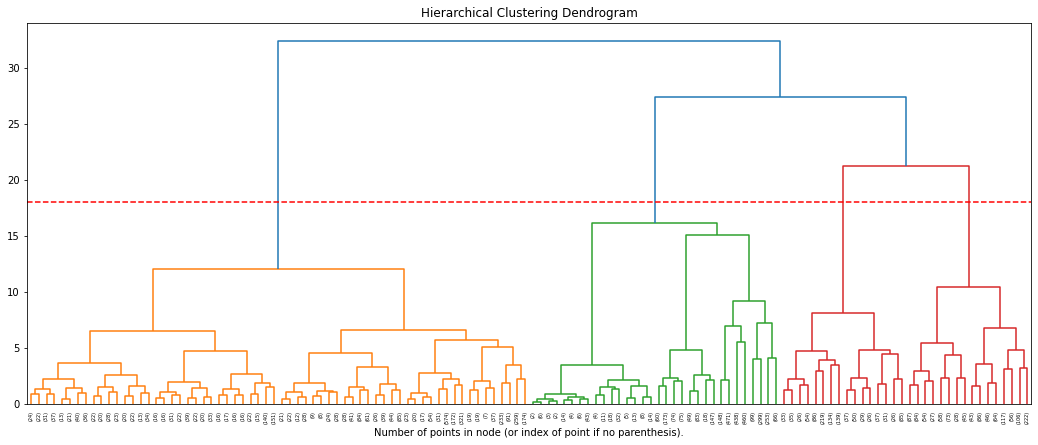

In [8]:
# plot the tree
plt.figure(figsize=(18, 7))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model_whole, truncate_mode='level', p=6)  # plot the top five levels
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

plt.axhline(y=18, color='r', linestyle='--')
plt.show()

In [9]:
# create a model with only four clusters
model_4 = AgglomerativeClustering(n_clusters=4)  
labels = model_4.fit_predict(data_norm)

data.insert(loc=1, column='LABEL', value=labels)
data.head(10)

,CUST_ID,LABEL,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,1,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,1,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,C10005,0,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,2,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,1,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,0,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,1,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


## 3. Visualization through PCA

In [23]:
# fit a PCA model on the normalized dataset
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_norm)

print(data_pca.shape)

(8950, 2)


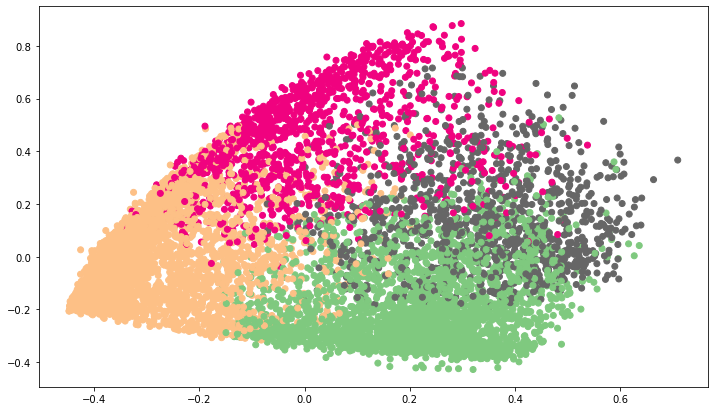

In [24]:
# Visualization
plt.figure(figsize=(12, 7))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='Accent')

## 4. Interpretation